# Do you need psuedo labels?

# You might need a token for space itself? start and stop tokens?

# Sentiment Classification model with test as well in train? Will increase the vocab size as well?

# * https://www.tensorflow.org/tutorials/text/transformer
# * https://pytorch.org/tutorials/beginner/transformer_tutorial.html

## Settings

In [1]:
# CONTROLS
MODEL_PREFIX = "V13"
MODEL_NUMBER = MODEL_PREFIX[-2:]
TRAIN_SPLIT_RATIO = 0.8

DROPOUT = 0.3
MIN_LR = 1e-6
MAX_LR = 1e-3
BATCH_SIZE = 1024
PREDICT_BATCH_SIZE = 2048
STEP_SIZE = 10
CLR_METHOD = "triangular" # exp_range, triangular, triangular2
NUM_EPOCHS = 100

## Libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

#from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import pickle, os, sys, re

import spacy
from spacy.lang.en import English

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, Embedding, Dense, concatenate, MaxPooling2D, Softmax, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Reshape, Activation, Bidirectional, TimeDistributed
from tensorflow.keras.layers import RepeatVector, Multiply, MaxPooling1D, Layer
from tensorflow.keras.activations import softmax
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

%matplotlib inline

In [3]:
#https://www.kaggle.com/qqgeogor/keras-lstm-attention-glove840b-lb-0-043
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
    
    def get_config(self):
        config = {'step_dim': self.step_dim}
        base_config = super(Attention,self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [4]:
from tensorflow.keras.callbacks import *
import tensorflow.keras.backend as K

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [5]:
pd.set_option('display.max_colwidth', -1)
np.random.seed(54321)

c:\users\deepak\miniconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


## Import Data

In [6]:
df = pd.read_csv("../data/train.csv",
                 encoding="utf8")

print(pd.concat((df.dtypes, df.isna().sum()), axis=1))
print(df.shape)

# Counts of various columns
print({i:df[i].nunique() for i in df.columns})
print(df.describe()) #.astype(int)
df.head(2)

                    0  1
textID         object  0
text           object  1
selected_text  object  1
sentiment      object  0
(27481, 4)
{'textID': 27481, 'text': 27480, 'selected_text': 22463, 'sentiment': 3}
            textID            text selected_text sentiment
count   27481       27480           27480         27481   
unique  27481       27480           22463         3       
top     004eb1e239  sunburnt again  good          neutral 
freq    1           1               199           11118   


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative


In [7]:
test_df = pd.read_csv("../data/test.csv")
print(pd.concat((test_df.dtypes, test_df.isna().sum()), axis=1))
print(test_df.shape)

# Counts of various columns
print({i:test_df[i].nunique() for i in test_df.columns})
print(test_df.describe())
test_df.head(2)

                0  1
textID     object  0
text       object  0
sentiment  object  0
(3534, 3)
{'textID': 3534, 'text': 3534, 'sentiment': 3}
            textID  \
count   3534         
unique  3534         
top     40e1ca4ab0   
freq    1            

                                                                             text  \
count   3534                                                                        
unique  3534                                                                        
top     I`m gonna cry    I went bad at my History test ! I really hate History  !   
freq    1                                                                           

       sentiment  
count   3534      
unique  3         
top     neutral   
freq    1430      


,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China: (SH) (BJ).,positive


In [8]:
df.loc[df['text'].astype('str').apply(lambda x : len(re.findall(pattern="ï¿½", string=x))>0)].head(2)

,textID,text,selected_text,sentiment
44,c77717b103,I love to! But I`m only available from 5pm. and where dear? Would love to help convert her vids.ï¿½,I love to!,positive
192,28dbada620,*phew* Will make a note in case anyone else runs into the same issueï¿½,*phew* Will make a note in case anyone else runs into the same issueï¿½,neutral


In [9]:
test_df.loc[test_df['text'].astype('str').apply(lambda x : len(re.findall(pattern="ï¿½", string=x))>0)].head(2)

,textID,text,sentiment
145,7223fdccc2,tikcets are only ï¿½91...each...BUT I SO WANT TO GO,positive
618,43ad351369,"AHHH - Whatchu talkinï¿½ baby? HAHAHA I canï¿½t believe youu:O heh, actually I can. Life is worth taking risks... http://tumblr.com/xs81qy54s",positive


## Exploration

#### Sentiment count in training

In [10]:
pd.concat([df.groupby("sentiment")[["text"]].count(), test_df.groupby("sentiment")[["text"]].count()], axis=1)

,text,text
sentiment,,
negative,7781,1001
neutral,11117,1430
positive,8582,1103


## Preprocessing

#### Cleaning

In [11]:
# For traceability
df["original_index"] = df.index
test_df["original_index"] = test_df.index

In [12]:
print(df.shape)
df = df[(~df.text.isna())]
df = df.reset_index(drop=True)
df = df.copy()
print(df.shape)

(27481, 5)
(27480, 5)


In [13]:
df["sentiment_code"] = df["sentiment"].astype("category")
X_sentiments = df["sentiment_code"].cat.codes.values

test_df["sentiment_code"] = test_df["sentiment"].astype("category")
X_sentiments_test = test_df["sentiment_code"].cat.codes.values

In [14]:
df["text"] = df["text"].astype(str)
df["selected_text"] = df["selected_text"].astype(str)
test_df["text"] = test_df["text"].astype(str)

#### Tagging

In [15]:
def preprocess_text(x, extra_string=None):
    x = x.lower()
    x = re.sub('([!"#$%&()*+,-./:;\'<=>?@[\\]^_{|}~\t\n])', ' \\1 ', x) # Not including ` here since used in couldn`t, isn`t
    x = x.strip()
    x = re.sub(' +', ' ', x)
    x = x.split(" ")
    if extra_string is not None:
        x = ["xxxSTART"] + x + ["xxxSENTIMENT"] + [extra_string] + ["xxxEND"]
    return x

In [16]:
def get_extremities(l_string, s_string, extra_string, print_it=False):
    l_string = preprocess_text(l_string, extra_string)
    s_string = preprocess_text(s_string, extra_string=None)
    
    len_l = len(l_string)
    len_s = len(s_string)
    
    for i in range(len_l - len_s + 1):
        if (i + len_s) <= len_l:
            substring = l_string[i:i+len_s]
            if substring == s_string:
                if print_it:
                    print(l_string)
                    print(substring)
                    print(i, i+len_s, substring)
                
                start_vector, end_vector = np.zeros(len_l, dtype=np.int16), np.zeros(len_l, dtype=np.int16)
                att_vector = np.ones(len_l, dtype=np.int16)
                start_vector[i], end_vector[i+len_s-1] = 1, 1
                
                return (l_string, s_string, start_vector, end_vector, att_vector)

In [17]:
idx = 100
get_extremities(df.text[idx], df.selected_text[idx], df.sentiment[idx], print_it=False)

(['xxxSTART',
  '4am',
  '.',
  'and',
  'im',
  'on',
  'the',
  'beach',
  '.',
  'pretty',
  'xxxSENTIMENT',
  'positive',
  'xxxEND'],
 ['pretty'],
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int16),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int16),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int16))

In [18]:
df[["text_mod", "selected_text_mod", "target_start", "target_stop", "target_atten"]] = df.apply(lambda x: get_extremities(x.text, x.selected_text, x.sentiment), axis=1).apply(pd.Series)
test_df[["text_mod"]] = test_df.apply(lambda x: [preprocess_text(x.text, extra_string = x.sentiment)], axis=1).apply(pd.Series)

In [19]:
df.isna().sum()

textID               0   
text                 0   
selected_text        0   
sentiment            0   
original_index       0   
sentiment_code       0   
text_mod             1476
selected_text_mod    1476
target_start         1476
target_stop          1476
target_atten         1476
dtype: int64

In [20]:
test_df.isna().sum()

textID            0
text              0
sentiment         0
original_index    0
sentiment_code    0
text_mod          0
dtype: int64

In [21]:
df.head(2)

,textID,text,selected_text,sentiment,original_index,sentiment_code,text_mod,selected_text_mod,target_start,target_stop,target_atten
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,0,neutral,"[xxxSTART, i`d, have, responded, ,, if, i, were, going, xxxSENTIMENT, neutral, xxxEND]","[i`d, have, responded, ,, if, i, were, going]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,1,negative,"[xxxSTART, sooo, sad, i, will, miss, you, here, in, san, diego, !, !, !, xxxSENTIMENT, negative, xxxEND]","[sooo, sad]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


In [22]:
df.iloc[df.loc[df['target_start'].isna()].index].head(2)

,textID,text,selected_text,sentiment,original_index,sentiment_code,text_mod,selected_text_mod,target_start,target_stop,target_atten
18,af3fed7fc3,is back home now gonna miss every one,onna,negative,18,negative,NaN,NaN,NaN,NaN,NaN
32,1c31703aef,If it is any consolation I got my BMI tested hahaha it says I am obesed well so much for being unhappy for about 10 minutes.,well so much for being unhappy for about 10 minute,negative,32,negative,NaN,NaN,NaN,NaN,NaN


In [23]:
test_df.head(2)

,textID,text,sentiment,original_index,sentiment_code,text_mod
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,0,neutral,"[xxxSTART, last, session, of, the, day, http, :, /, /, twitpic, ., com, /, 67ezh, xxxSENTIMENT, neutral, xxxEND]"
1,96d74cb729,Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China: (SH) (BJ).,positive,1,positive,"[xxxSTART, shanghai, is, also, really, exciting, (, precisely, -, -, skyscrapers, galore, ), ., good, tweeps, in, china, :, (, sh, ), (, bj, ), ., xxxSENTIMENT, positive, xxxEND]"


In [24]:
anomalous_idxs = df.loc[df['target_start'].isna()].index.tolist()

In [25]:
print(df.shape)
df = df[~df.index.isin(anomalous_idxs)]
df = df.reset_index(drop=True)
df = df.copy()
print(df.shape)

(27480, 11)
(26004, 11)


#### Tokenization

In [26]:
X_words = df['text_mod'].apply(lambda x:list(x)).tolist()
X_att = df['target_atten'].apply(lambda x:list(x)).tolist()

X_words_test = test_df['text_mod'].apply(lambda x:list(x)).tolist()
X_att_test = [[1 for j in i] for i in X_words_test]

Y_words = df['selected_text_mod'].apply(lambda x:list(x)).tolist()
Y_starts = df['target_start'].apply(lambda x:list(x)).tolist()
Y_stops = df['target_stop'].apply(lambda x:list(x)).tolist()

print("\n",
    "X_words:","\t", len(X_words),"\n",
    "X_att:","\t", len(X_att),"\n",
    "Y_words:","\t", len(Y_words),"\n",
    "Y_starts:","\t", len(Y_starts),"\n",
    "Y_stops:","\t", len(Y_stops),"\n",
    "X_words_test:","\t", len(X_words_test),"\n",
    "X_att_test:","\t", len(X_att_test),"\n"
)


 X_words: 	 26004 
 X_att: 	 26004 
 Y_words: 	 26004 
 Y_starts: 	 26004 
 Y_stops: 	 26004 
 X_words_test: 	 3534 
 X_att_test: 	 3534 



In [27]:
print(sum([len(i)==len(j) for i,j in zip(X_att_test, X_words_test)]))
print(sum([len(i)==len(j) for i,j in zip(X_att, X_words)]))

3534
26004


In [28]:
from collections import Counter
word_counts = Counter([j for i in X_words for j in i])

X_unique_tokens = len(word_counts)
word_counts.most_common(10)

[('.', 33619),
 ('xxxSTART', 26004),
 ('xxxSENTIMENT', 26004),
 ('xxxEND', 26004),
 ('!', 14379),
 ('i', 12615),
 ('neutral', 10941),
 ('to', 9447),
 ('the', 8445),
 (',', 7984)]

In [29]:
MIN_WORD_FREQ = 2

In [30]:
word_subset = [i for i,j in word_counts.items() if j >= MIN_WORD_FREQ]
print("VOCAB reduced from", len(word_counts), "to", len(word_subset))

VOCAB reduced from 25847 to 10178


In [31]:
#list_of_words = set(sorted([j for i in X_words for j in i]))
#Y_list_of_words = set(sorted([j for i in Y_words for j in i]))

In [32]:
vocab_itos = {i+2:j for i,j in enumerate(word_subset)}
vocab_stoi = {j:i+2 for i,j in enumerate(word_subset)}

vocab_stoi["xxxUNK"] = 1
vocab_itos[1] = "xxxUNK"

vocab_stoi["xxxNone"] = 0
vocab_itos[0] = "xxxNone"

In [33]:
def get_from_vocab(vocab, word):
    try:
        value = vocab[word]
    except KeyError as k:
        value = vocab_stoi["xxxUNK"]
    return value

In [34]:
X = [[get_from_vocab(vocab_stoi,j) for j in i] for i in X_words]
Y = [[get_from_vocab(vocab_stoi,j) for j in i] for i in Y_words]
X_test = [[get_from_vocab(vocab_stoi,j) for j in i] for i in X_words_test]

In [35]:
max_len = max([len(i) for i in X])
VOCAB_SIZE = len(vocab_stoi)
print(VOCAB_SIZE, max_len)

10180 110


#### Train Validation  split

In [36]:
idx = [i for i in np.arange(len(Y))]
np.random.shuffle(idx)
train_idx, val_idx = idx[:round(TRAIN_SPLIT_RATIO*len(Y))], idx[round(TRAIN_SPLIT_RATIO * len(Y)):]

print(len(idx), len(train_idx), len(val_idx), len(train_idx) + len(val_idx))

26004 20803 5201 26004


In [37]:
X_train, X_val = [X[i] for i in train_idx], [X[i] for i in val_idx]
X_att_train, X_att_val = [X_att[i] for i in train_idx], [X_att[i] for i in val_idx]

Y_train, Y_val = [Y[i] for i in train_idx], [Y[i] for i in val_idx]
Y_starts_train, Y_starts_val = [Y_starts[i] for i in train_idx], [Y_starts[i] for i in val_idx]
Y_stops_train, Y_stops_val = [Y_stops[i] for i in train_idx], [Y_stops[i] for i in val_idx]

print("\n",
    len(X_train),"\t",": X_train","\n",
    len(X_att_train),"\t",": X_att_train","\n",
    len(Y_train),"\t",": Y_train","\n",
    len(Y_starts_train),"\t",": Y_starts_train","\n",
    len(Y_stops_train),"\t",": Y_stops_train","\n",
    len(X_val),"\t",": X_val","\n",
    len(X_att_val),"\t",": X_att_val","\n",
    len(Y_val),"\t",": Y_val","\n",
    len(Y_starts_val),"\t",": Y_starts_val","\n",
    len(Y_stops_val),"\t",": Y_stops_val","\n"
)


 20803 	 : X_train 
 20803 	 : X_att_train 
 20803 	 : Y_train 
 20803 	 : Y_starts_train 
 20803 	 : Y_stops_train 
 5201 	 : X_val 
 5201 	 : X_att_val 
 5201 	 : Y_val 
 5201 	 : Y_starts_val 
 5201 	 : Y_stops_val 



#### Padding

In [38]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [39]:
X_train = pad_sequences(X_train, maxlen=max_len, padding="post")
X_att_train = pad_sequences(X_att_train, maxlen=max_len, padding="post")
Y_train = pad_sequences(Y_train, maxlen=max_len, padding="post")
Y_starts_train = pad_sequences(Y_starts_train, maxlen=max_len, padding="post")
Y_stops_train = pad_sequences(Y_stops_train, maxlen=max_len, padding="post")

X_val = pad_sequences(X_val, maxlen=max_len, padding="post")
X_att_val = pad_sequences(X_att_val, maxlen=max_len, padding="post")
Y_val = pad_sequences(Y_val, maxlen=max_len, padding="post")
Y_starts_val = pad_sequences(Y_starts_val, maxlen=max_len, padding="post")
Y_stops_val = pad_sequences(Y_stops_val, maxlen=max_len, padding="post")

X_test = pad_sequences(X_test, maxlen=max_len, padding="post")
X_att_test = pad_sequences(X_att_test, maxlen=max_len, padding="post")

In [40]:
print("\n",
     X_train.shape, "\t: X_train ", "\n",
     X_att_train.shape, "\t: X_att_train ", "\n",
     Y_train.shape, "\t: Y_train ", "\n",
     Y_starts_train.shape, "\t: Y_starts_train ", "\n",
     Y_stops_train.shape, "\t: Y_stops_train ", "\n",

     X_val.shape, "\t: X_val ", "\n",
     X_att_val.shape, "\t: X_att_val ", "\n",
     Y_val.shape, "\t: Y_val ", "\n",
     Y_starts_val.shape, "\t: Y_starts_val ", "\n",
     Y_stops_val.shape, "\t: Y_stops_val ", "\n",

     X_test.shape, "\t: X_test ", "\n",
     X_att_test.shape, "\t: X_att_test ", "\n"
)


 (20803, 110) 	: X_train  
 (20803, 110) 	: X_att_train  
 (20803, 110) 	: Y_train  
 (20803, 110) 	: Y_starts_train  
 (20803, 110) 	: Y_stops_train  
 (5201, 110) 	: X_val  
 (5201, 110) 	: X_att_val  
 (5201, 110) 	: Y_val  
 (5201, 110) 	: Y_starts_val  
 (5201, 110) 	: Y_stops_val  
 (3534, 110) 	: X_test  
 (3534, 110) 	: X_att_test  



#### Checking for zero input vectors

In [41]:
print(np.argmax([X_train.sum(axis=1)==0]), np.min([X_train.sum(axis=1)]))
print(np.argmax([X_val.sum(axis=1)==0]), np.min([X_val.sum(axis=1)]))

0 36
0 36


#### Check inputs and outputs

In [42]:
#Train
num = 100
[[i,j,k,l,m] for i,j,k,l,m in zip(X_train[num],
                                  X_att_train[num],
                                  Y_train[num],
                                  Y_starts_train[num],
                                  Y_stops_train[num])]

[[2, 1, 1662, 0, 0],
 [87, 1, 648, 0, 0],
 [17, 1, 2533, 0, 0],
 [2174, 1, 7, 0, 0],
 [669, 1, 1685, 0, 0],
 [84, 1, 278, 0, 0],
 [1662, 1, 17, 1, 0],
 [648, 1, 229, 0, 0],
 [2533, 1, 4625, 0, 0],
 [7, 1, 116, 0, 0],
 [1685, 1, 44, 0, 0],
 [278, 1, 406, 0, 0],
 [17, 1, 8227, 0, 0],
 [229, 1, 0, 0, 0],
 [4625, 1, 0, 0, 0],
 [116, 1, 0, 0, 0],
 [44, 1, 0, 0, 0],
 [406, 1, 0, 0, 0],
 [8227, 1, 0, 0, 1],
 [7492, 1, 0, 0, 0],
 [10, 1, 0, 0, 0],
 [11, 1, 0, 0, 0],
 [12, 1, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 

In [43]:
#Val
num = 100
[[i,j,k,l,m] for i,j,k,l,m in zip(X_val[num],
                                  X_att_val[num],
                                  Y_val[num],
                                  Y_starts_val[num],
                                  Y_stops_val[num])]

[[2, 1, 9890, 0, 0],
 [9890, 1, 8753, 1, 0],
 [8753, 1, 55, 0, 0],
 [55, 1, 4465, 0, 0],
 [4465, 1, 305, 0, 0],
 [305, 1, 1, 0, 0],
 [1, 1, 28, 0, 0],
 [28, 1, 0, 0, 1],
 [47, 1, 0, 0, 0],
 [48, 1, 0, 0, 0],
 [49, 1, 0, 0, 0],
 [49, 1, 0, 0, 0],
 [50, 1, 0, 0, 0],
 [28, 1, 0, 0, 0],
 [1, 1, 0, 0, 0],
 [28, 1, 0, 0, 0],
 [51, 1, 0, 0, 0],
 [49, 1, 0, 0, 0],
 [1, 1, 0, 0, 0],
 [49, 1, 0, 0, 0],
 [9890, 1, 0, 0, 0],
 [28, 1, 0, 0, 0],
 [7327, 1, 0, 0, 0],
 [10, 1, 0, 0, 0],
 [11, 1, 0, 0, 0],
 [12, 1, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],


In [44]:
#Test
num = 100
[[i,j,k] for i,j,k in zip(X_words_test[num],
                          X_test[num],
                          X_att_test[num])]

[['xxxSTART', 2, 1],
 ['oooh', 3482, 1],
 [',', 5, 1],
 ['sunshine', 1726, 1],
 ['!', 22, 1],
 ['a', 142, 1],
 ['patch', 905, 1],
 ['of', 34, 1],
 ['sunshine', 1726, 1],
 ['!', 22, 1],
 ['and', 68, 1],
 ['it', 144, 1],
 ['will', 15, 1],
 ['be', 89, 1],
 ['gone', 544, 1],
 ['by', 106, 1],
 ['the', 42, 1],
 ['time', 504, 1],
 ['i', 7, 1],
 ['leave', 31, 1],
 ['work', 342, 1],
 ['and', 68, 1],
 ['replaced', 1, 1],
 ['with', 278, 1],
 ['rain', 1901, 1],
 ['.', 28, 1],
 ['/', 49, 1],
 ['vent', 9146, 1],
 ['xxxSENTIMENT', 10, 1],
 ['neutral', 11, 1],
 ['xxxEND', 12, 1]]

## Model

In [45]:
input_att_flags = Input((max_len), name="att_flags")
input_sequences = Input((max_len), name="words")

emb_sequences = Embedding(input_dim=VOCAB_SIZE, input_length=max_len, output_dim=64, mask_zero=True)(input_sequences)

seq = Bidirectional(LSTM(32, activation=None, return_sequences=True))(emb_sequences)
seq = BatchNormalization()(seq)
seq = Activation("relu")(seq)
seq = Dropout(DROPOUT)(seq)

seq = Bidirectional(LSTM(32, activation=None, return_sequences=True))(seq)
seq = BatchNormalization()(seq)
seq = Activation("relu")(seq)
seq = Dropout(DROPOUT)(seq)

seq = Bidirectional(LSTM(32, activation=None, return_sequences=True))(seq)
seq = Attention(max_len)(seq)
seq = BatchNormalization()(seq)
seq = Activation("relu")(seq)
seq = Dropout(DROPOUT)(seq)

seq = Dense(max_len, activation="relu")(seq)
seq = BatchNormalization()(seq)
seq = Dropout(DROPOUT)(seq)

att = Dense(max_len, activation="relu")(input_att_flags)
att = BatchNormalization()(att)
att = Dropout(DROPOUT)(att)

convs = Conv1D(filters=32, kernel_size=8, padding="same", activation=None)(emb_sequences)
convs = BatchNormalization()(convs)
convs = Activation("relu")(convs)
convs = MaxPooling1D(pool_size=2, strides=1)(convs)
convs = Dropout(DROPOUT)(convs)

convs = Conv1D(filters=32, kernel_size=8, padding="same", activation=None)(convs)
convs = BatchNormalization()(convs)
convs = Activation("relu")(convs)
convs = MaxPooling1D(pool_size=2, strides=1)(convs)
convs = Dropout(DROPOUT)(convs)

convs = Conv1D(filters=32, kernel_size=8, padding="same", activation=None)(convs)
convs = BatchNormalization()(convs)
convs = Activation("relu")(convs)
convs = MaxPooling1D(pool_size=2, strides=1)(convs)
convs = Dropout(DROPOUT)(convs)

convs = Flatten()(convs)
convs = Dense(max_len, activation=None)(convs)
convs = BatchNormalization()(convs)
convs = Activation("relu")(convs)
convs = Dropout(DROPOUT)(convs)

conv = Multiply()([att, convs])
seq = Multiply()([att, seq])
concat_layer = concatenate([conv, seq])

output_starts = Dense(max_len, activation=None)(concat_layer)
output_starts = BatchNormalization()(output_starts)
output_starts = Activation("relu")(output_starts)
output_starts = Dropout(DROPOUT)(output_starts)

output_starts = Dense(max_len, activation=None)(output_starts)
output_starts = Activation("relu")(output_starts)

output_stops = Dense(max_len, activation=None)(concat_layer)
output_stops = BatchNormalization()(output_stops)
output_stops = Activation("relu")(output_stops)
output_stops = Dropout(DROPOUT)(output_stops)

output_stops = Dense(max_len, activation=None)(output_stops)
output_stops = Activation("relu")(output_stops)

output_starts = Dense(max_len, activation='softmax', name="starts")(output_starts)
output_stops = Dense(max_len, activation='softmax', name="stops")(output_stops)

In [46]:
model = Model([input_att_flags, input_sequences], [output_starts, output_stops])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              [(None, 110)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 110, 64)      651520      words[0][0]                      
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 110, 32)      16416       embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 110, 32)      128         conv1d[0][0]                     
______________________________________________________________________________________________

In [47]:
adam = Adam(learning_rate=MIN_LR)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam , metrics=['accuracy'])

In [48]:
#callbacks
mcp = ModelCheckpoint(filepath="../results/"+MODEL_PREFIX+"BestCheckpoint.h5",
                      monitor='val_loss',
                      mode="auto",
                      save_weights_only=False,
                      save_best_only=True)

clr = CyclicLR(mode=CLR_METHOD,
               base_lr=MIN_LR,
               max_lr=MAX_LR,
               step_size= STEP_SIZE * (X_train.shape[0] // BATCH_SIZE))

In [49]:
history = model.fit(x={"att_flags":X_att_train,
                       "words":X_train},
                    y={"starts":Y_starts_train.argmax(axis=1),
                       "stops":Y_stops_train.argmax(axis=1)},
                    shuffle=True,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=({"att_flags":X_att_val, "words":X_val},
                                     {"starts":Y_starts_val.argmax(axis=1), "stops":Y_stops_val.argmax(axis=1)}),
                    verbose=1,
                    callbacks=[clr, mcp]) #es, rlrop, tb, mcp,

Train on 20803 samples, validate on 5201 samples
Epoch 1/100
20803/20803 [==============================] - 33s 2ms/sample - loss: 9.7259 - starts_loss: 4.8958 - stops_loss: 4.8268 - starts_accuracy: 0.0065 - stops_accuracy: 0.0101 - val_loss: 9.3942 - val_starts_loss: 4.6981 - val_stops_loss: 4.6955 - val_starts_accuracy: 0.0081 - val_stops_accuracy: 0.0406
Epoch 2/100
20803/20803 [==============================] - 18s 860us/sample - loss: 9.3171 - starts_loss: 4.6140 - stops_loss: 4.6894 - starts_accuracy: 0.0274 - stops_accuracy: 0.0237 - val_loss: 9.3201 - val_starts_loss: 4.6479 - val_stops_loss: 4.6718 - val_starts_accuracy: 0.2665 - val_stops_accuracy: 0.0461
Epoch 3/100
20803/20803 [==============================] - 18s 852us/sample - loss: 8.3595 - starts_loss: 3.9277 - stops_loss: 4.4009 - starts_accuracy: 0.3430 - stops_accuracy: 0.0532 - val_loss: 9.0809 - val_starts_loss: 4.4772 - val_stops_loss: 4.6035 - val_starts_accuracy: 0.5999 - val_stops_accuracy: 0.0473
Epoch 4/100

Epoch 27/100
20803/20803 [==============================] - 18s 851us/sample - loss: 3.2531 - starts_loss: 1.5632 - stops_loss: 1.6910 - starts_accuracy: 0.5985 - stops_accuracy: 0.5523 - val_loss: 3.7717 - val_starts_loss: 1.8773 - val_stops_loss: 1.9375 - val_starts_accuracy: 0.5999 - val_stops_accuracy: 0.4880
Epoch 28/100
20803/20803 [==============================] - 18s 852us/sample - loss: 3.2288 - starts_loss: 1.5584 - stops_loss: 1.6673 - starts_accuracy: 0.5985 - stops_accuracy: 0.5579 - val_loss: 3.6738 - val_starts_loss: 1.8546 - val_stops_loss: 1.8614 - val_starts_accuracy: 0.5999 - val_stops_accuracy: 0.5061
Epoch 29/100
20803/20803 [==============================] - 18s 863us/sample - loss: 3.2164 - starts_loss: 1.5529 - stops_loss: 1.6644 - starts_accuracy: 0.5985 - stops_accuracy: 0.5598 - val_loss: 3.5364 - val_starts_loss: 1.8160 - val_stops_loss: 1.7583 - val_starts_accuracy: 0.5999 - val_stops_accuracy: 0.5334
Epoch 30/100
20803/20803 [=============================

20803/20803 [==============================] - 18s 847us/sample - loss: 2.8474 - starts_loss: 1.4072 - stops_loss: 1.4417 - starts_accuracy: 0.5996 - stops_accuracy: 0.5960 - val_loss: 3.2038 - val_starts_loss: 1.6611 - val_stops_loss: 1.5935 - val_starts_accuracy: 0.5893 - val_stops_accuracy: 0.5789
Epoch 54/100
20803/20803 [==============================] - 18s 854us/sample - loss: 2.8402 - starts_loss: 1.4091 - stops_loss: 1.4320 - starts_accuracy: 0.6006 - stops_accuracy: 0.5994 - val_loss: 3.1671 - val_starts_loss: 1.6273 - val_stops_loss: 1.5902 - val_starts_accuracy: 0.5899 - val_stops_accuracy: 0.5812
Epoch 55/100
20803/20803 [==============================] - 18s 846us/sample - loss: 2.8387 - starts_loss: 1.4032 - stops_loss: 1.4372 - starts_accuracy: 0.5994 - stops_accuracy: 0.5968 - val_loss: 3.1456 - val_starts_loss: 1.6102 - val_stops_loss: 1.5838 - val_starts_accuracy: 0.5908 - val_stops_accuracy: 0.5824
Epoch 56/100
20803/20803 [==============================] - 18s 847u

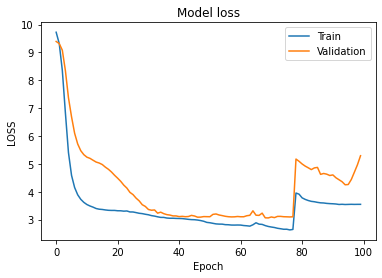

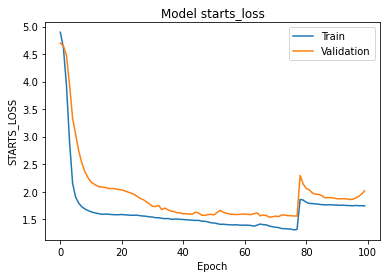

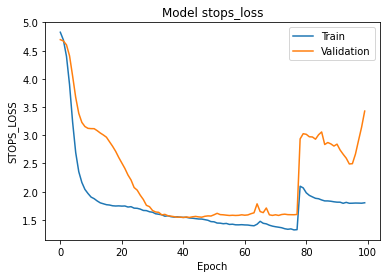

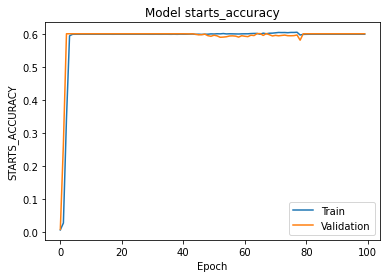

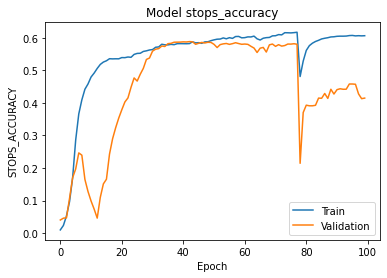

In [50]:
#metric_names = ['loss' ,'accuracy']
metric_names = ["loss", "starts_loss", "stops_loss", "starts_accuracy", "stops_accuracy"]

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.title('Model '+i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

## Validation

#### Inference

In [51]:
model.save("../results/"+MODEL_PREFIX+"EndCheckpoint.h5")

In [52]:
from tensorflow.keras.models import load_model

model = tf.keras.models.load_model(
    filepath="../results/"+MODEL_PREFIX+"BestCheckpoint.h5",
    custom_objects={'Attention' : Attention},
    compile=True
)

In [53]:
model.evaluate(x = {"att_flags":X_att_val, "words":X_val},
               y={"starts":Y_starts_val.argmax(axis=1), "stops":Y_stops_val.argmax(axis=1)},
               batch_size=PREDICT_BATCH_SIZE)

5201/5201 [==============================] - 2s 374us/sample - loss: 3.0618 - starts_loss: 1.5141 - stops_loss: 1.5470 - starts_accuracy: 0.5933 - stops_accuracy: 0.5807


[3.06181281279014, 1.5141406, 1.5470133, 0.59334743, 0.58065754]

In [54]:
pred_train = model.predict(x = {"att_flags":X_att_train, "words":X_train},
                           batch_size=PREDICT_BATCH_SIZE)
pred_val = model.predict(x = {"att_flags":X_att_val, "words":X_val},
                         batch_size=PREDICT_BATCH_SIZE)
pred_test = model.predict(x = {"att_flags":X_att_test, "words":X_test},
                          batch_size=PREDICT_BATCH_SIZE)

In [55]:
pred_starts_train, pred_stops_train = pred_train[0], pred_train[1]
pred_starts_val, pred_stops_val = pred_val[0], pred_val[1]
pred_starts_test, pred_stops_test = pred_test[0], pred_test[1]

In [56]:
print(pred_starts_train.shape, pred_stops_train.shape)
print(pred_starts_val.shape, pred_stops_val.shape)
print(pred_starts_test.shape, pred_stops_test.shape)

(20803, 110) (20803, 110)
(5201, 110) (5201, 110)
(3534, 110) (3534, 110)


In [57]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

In [58]:
preds = {
    "train":{
        "starts":{
            "y_true":Y_starts_train.argmax(axis=1),
            "y_pred":pred_starts_train.argmax(axis=1)
        },
        "stops":{
            "y_true":Y_stops_train.argmax(axis=1),
            "y_pred":pred_stops_train.argmax(axis=1)
        }
    },
    "valid":{
        "starts":{
            "y_true":Y_starts_val.argmax(axis=1),
            "y_pred":pred_starts_val.argmax(axis=1)
        },
        "stops":{
            "y_true":Y_stops_train.argmax(axis=1),
            "y_pred":pred_stops_train.argmax(axis=1)
        }        
    }
}

In [59]:
def print_metrics():
    funcs = [accuracy_score, f1_score, precision_score, recall_score, confusion_matrix]
    for f in funcs:
        for data_set in ["train","valid"]:
            for var in ["starts", "stops"]:
                if f in [accuracy_score]:
                    res = f(**preds[data_set][var])
                    print("{:.2f}".format(100 * res), "\t||", data_set, "\t||", var, "\t||", f.__name__)
                elif f in [confusion_matrix]:
                    res = f(**preds[data_set][var], labels = np.arange(max_len))
                    np.savetxt(X=res, fmt='%i', delimiter=",",
                               fname="../results/ConfusionMatrix_"+MODEL_PREFIX+"_"+data_set+"_"+var+".csv")
                    print("\t||", data_set, "\t||", var, "\t||", f.__name__, "\t||", 
                          "../results/ConfusionMatrix_"+MODEL_PREFIX+"_"+data_set+"_"+var+".csv")
                else:
                    res = f(**preds[data_set][var], average="macro")
                    print("{:.2f}".format(100 * res), "\t||", data_set, "\t||", var, "\t||", f.__name__)
        print("================================================================")

print_metrics()

60.68 	|| train 	|| starts 	|| accuracy_score
64.03 	|| train 	|| stops 	|| accuracy_score
59.33 	|| valid 	|| starts 	|| accuracy_score
64.03 	|| valid 	|| stops 	|| accuracy_score
7.08 	|| train 	|| starts 	|| f1_score
51.86 	|| train 	|| stops 	|| f1_score
5.10 	|| valid 	|| starts 	|| f1_score
51.86 	|| valid 	|| stops 	|| f1_score
9.68 	|| train 	|| starts 	|| precision_score
51.62 	|| train 	|| stops 	|| precision_score
5.71 	|| valid 	|| starts 	|| precision_score
51.62 	|| valid 	|| stops 	|| precision_score
7.97 	|| train 	|| starts 	|| recall_score
54.88 	|| train 	|| stops 	|| recall_score
6.08 	|| valid 	|| starts 	|| recall_score
54.88 	|| valid 	|| stops 	|| recall_score


c:\users\deepak\miniconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	|| train 	|| starts 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V13_train_starts.csv
	|| train 	|| stops 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V13_train_stops.csv
	|| valid 	|| starts 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V13_valid_starts.csv
	|| valid 	|| stops 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V13_valid_stops.csv


#### Postprocessing

In [60]:
Y_words_train = [[vocab_itos[j] for j in i if j!=0] for num,i in enumerate(Y_train)]
Y_words_val = [[vocab_itos[j] for j in i if j!=0] for num,i in enumerate(Y_val)]

In [61]:
print(sum([s<e for s,e in zip(pred_starts_train.argmax(axis=1), pred_stops_train.argmax(axis=1))]))
print(sum([s<e for s,e in zip(pred_starts_val.argmax(axis=1), pred_stops_val.argmax(axis=1))]))
print(sum([s<e for s,e in zip(pred_starts_test.argmax(axis=1), pred_stops_test.argmax(axis=1))]))

20557
5161
3499


In [62]:
pred_words_train = [t[s:e+1] if s<e else t[e:-3] for t,s,e in zip([[vocab_itos[j] for j in i  if j!=0] for i in X_train], pred_starts_train.argmax(axis=1), pred_stops_train.argmax(axis=1))]
pred_words_val = [t[s:e+1] if s<e else t[e:-3] for t,s,e in zip([[vocab_itos[j] for j in i  if j!=0] for i in X_val], pred_starts_val.argmax(axis=1), pred_stops_val.argmax(axis=1))]
pred_words_test = [t[s:e+1] if s<e else t[e:-3] for t,s,e in zip([[vocab_itos[j] for j in i  if j!=0] for i in X_test], pred_starts_test.argmax(axis=1), pred_stops_test.argmax(axis=1))]

In [63]:
def jaccard(str1, str2):
    a = set(str1)
    b = set(str2)
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [64]:
print("Training Jaccard Score", np.mean([jaccard(str1=i, str2=j) for i,j in zip(Y_words_train, pred_words_train)]))
print("Validation Jaccard Score", np.mean([jaccard(str1=i, str2=j) for i,j in zip(Y_words_val, pred_words_val)]))

Training Jaccard Score 0.6563696002060264
Validation Jaccard Score 0.6136025498482669


In [65]:
sent_labels = {i:j for i,j in enumerate(df.sentiment_code.cat.categories)}

#### Spot Checks

In [66]:
def spot_check(index_to_check, mode):
    print("================== Sample #", index_to_check, "==================")
    if mode == "train":
        print("Selected_text:")
        print('\t', Y_words[train_idx[index_to_check]])
        print("Predicted_text:")
        print('\t', pred_words_train[index_to_check])
        print("Predictions:")
        print('\t',*[["%.2f"%j, 
                      "%.2f"%k,
                      i,
                      X_words[train_idx[index_to_check]][num]] for num, (i,j,k) in enumerate(zip(X_train[index_to_check].tolist(),
                                                                                               pred_starts_train[index_to_check].tolist(),
                                                                                               pred_stops_train[index_to_check].tolist())) if i!=0], sep="\n\t")
        
    elif mode == "validation":
        print("Selected_text:")
        print('\t', Y_words[val_idx[index_to_check]])
        print("Predicted_text:")
        print('\t', pred_words_val[index_to_check])
        print("Predictions:")
        print('\t',*[["%.2f"%j, 
                      "%.2f"%k,
                      i,
                      X_words[val_idx[index_to_check]][num]] for num, (i,j,k) in enumerate(zip(X_val[index_to_check].tolist(),
                                                                                               pred_starts_val[index_to_check].tolist(),
                                                                                               pred_stops_val[index_to_check].tolist())) if i!=0], sep="\n\t")
        
    else:
        print("Selected_text:")
        print('\t', "Not Available")
        print("Predicted_text:")
        print('\t', pred_words_test[index_to_check])
        print("Predictions:")
        print('\t',*[["%.2f"%j, 
                      "%.2f"%k,
                      i,
                      X_words_test[index_to_check][num]] for num, (i,j,k) in enumerate(zip(X_test[index_to_check].tolist(),
                                                                                               pred_starts_test[index_to_check].tolist(),
                                                                                               pred_stops_test[index_to_check].tolist())) if i!=0], sep="\n\t")

In [67]:
for i in range(10,20):
    spot_check(i, mode="train")

================== Sample # 10 ==================
Selected_text:
	 ['says', 'good', '(', 'or', 'should', 'i', 'say', 'bad', '?', ')', 'afternoon', '!']
Predicted_text:
	 ['says', 'good', '(', 'or', 'should', 'i', 'say', 'bad', '?', ')', 'afternoon', '!', 'http']
Predictions:
	
	['0.00', '0.00', 2, 'xxxSTART']
	['0.82', '0.02', 1103, 'says']
	['0.02', '0.03', 448, 'good']
	['0.06', '0.03', 81, '(']
	['0.02', '0.03', 758, 'or']
	['0.02', '0.01', 350, 'should']
	['0.01', '0.03', 7, 'i']
	['0.01', '0.02', 460, 'say']
	['0.01', '0.03', 318, 'bad']
	['0.00', '0.04', 74, '?']
	['0.01', '0.05', 84, ')']
	['0.01', '0.07', 1434, 'afternoon']
	['0.00', '0.14', 22, '!']
	['0.00', '0.14', 47, 'http']
	['0.00', '0.03', 48, ':']
	['0.00', '0.01', 49, '/']
	['0.00', '0.01', 49, '/']
	['0.00', '0.02', 376, 'plurk']
	['0.00', '0.08', 28, '.']
	['0.00', '0.01', 51, 'com']
	['0.00', '0.00', 49, '/']
	['0.00', '0.01', 95, 'p']
	['0.00', '0.03', 49, '/']
	['0.00', '0.14', 1, 'wxpdj']
	['0.00', '0.00', 10, '

In [68]:
for i in range(200,210):
    spot_check(i, mode="validation")

================== Sample # 200 ==================
Selected_text:
	 ['bad', 'day', 'the', 'day', 'you', 'realize', 'what', 'mess', 'you`ve', 'put', 'me', 'through', 'will', 'be', 'one', 'of', 'the', 'happiest', 'days', 'of', 'my', 'life', '.', '.', '.']
Predicted_text:
	 ['bad', 'day', 'the', 'day', 'you', 'realize', 'what', 'mess', 'you`ve', 'put', 'me', 'through', 'will', 'be', 'one', 'of', 'the', 'happiest', 'days', 'of', 'my', 'life', '.', '.', '.']
Predictions:
	
	['0.00', '0.00', 2, 'xxxSTART']
	['0.90', '0.00', 318, 'bad']
	['0.00', '0.00', 286, 'day']
	['0.01', '0.00', 42, 'the']
	['0.00', '0.00', 286, 'day']
	['0.00', '0.00', 17, 'you']
	['0.00', '0.00', 972, 'realize']
	['0.00', '0.00', 29, 'what']
	['0.00', '0.00', 345, 'mess']
	['0.00', '0.00', 973, 'you`ve']
	['0.01', '0.00', 39, 'put']
	['0.00', '0.00', 27, 'me']
	['0.00', '0.00', 247, 'through']
	['0.00', '0.00', 15, 'will']
	['0.00', '0.00', 89, 'be']
	['0.00', '0.00', 310, 'one']
	['0.00', '0.00', 34, 'of']
	['0.00', '

In [99]:
for i in range(0,20):
    spot_check(i, mode="test")

================== Sample # 0 ==================
Selected_text:
	 Not Available
Predicted_text:
	 ['last', 'session', 'of', 'the', 'day', 'http', ':', '/', '/', 'twitpic', '.', 'com', '/', 'xxxUNK']
Predictions:
	
	['0.00', '0.00', 2, 'xxxSTART']
	['0.76', '0.05', 285, 'last']
	['0.04', '0.07', 7417, 'session']
	['0.10', '0.05', 34, 'of']
	['0.05', '0.06', 42, 'the']
	['0.04', '0.12', 286, 'day']
	['0.01', '0.06', 47, 'http']
	['0.01', '0.06', 48, ':']
	['0.00', '0.07', 49, '/']
	['0.00', '0.03', 49, '/']
	['0.00', '0.02', 914, 'twitpic']
	['0.00', '0.02', 28, '.']
	['0.00', '0.01', 51, 'com']
	['0.00', '0.03', 49, '/']
	['0.00', '0.34', 1, '67ezh']
	['0.00', '0.00', 10, 'xxxSENTIMENT']
	['0.00', '0.00', 11, 'neutral']
	['0.00', '0.00', 12, 'xxxEND']
================== Sample # 1 ==================
Selected_text:
	 Not Available
Predicted_text:
	 ['xxxUNK', 'is', 'also', 'really']
Predictions:
	
	['0.00', '0.00', 2, 'xxxSTART']
	['0.30', '0.06', 1, 'shanghai']
	['0.08', '0.07', 26, 'is

## Submission

In [116]:
test_df['start'] = pred_starts_test.argmax(axis=1)
test_df['stop'] = pred_stops_test.argmax(axis=1)

In [117]:
def rejoin(x, s, e):
    return " ".join(x[s:e])

In [118]:
test_df['selected_text'] = [rejoin(i,j,k+1) for i,j,k in zip(test_df['text_mod'], test_df['start'], test_df['stop'] )]

In [120]:
test_df[["text", "sentiment","selected_text"]].tail(5)

,text,sentiment,selected_text
3529,"its at 3 am, im very tired but i can`t sleep but i try it",negative,"its at 3 am , im very tired but i can`t sleep but i try it"
3530,"All alone in this old house again. Thanks for the net which keeps me alive and kicking! Whoever invented the net, i wanna kiss your hair!",positive,thanks for
3531,I know what you mean. My little dog is sinking into depression... he wants to move someplace tropical,negative,. .
3532,_sutra what is your next youtube video gonna be about? I love your videos!,positive,your videos !
3533,http://twitpic.com/4woj2 - omgssh ang cute ng bby.!,positive,omgssh ang cute ng
